# Evidence calculation for the LDL Confidently Biased model

In [1]:
from numpy import pi, log
import pypolychord
from pypolychord.priors import UniformPrior
try:
    from mpi4py import MPI
except ImportError:
    pass
from chiborg import jk_data, jk_hyp, jk_calc, tm_prior
from chiborg.util import get_mut_info
import numpy as np
from scipy.stats import norm
from scipy.stats import uniform
from scipy.stats import multivariate_normal
from more_itertools import powerset
import random
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd

In [ ]:
# Input your data file and select relevant sheet/rows
file_path = '/home/quantom97/Documents/Dissertation Python Work/H0 measurements.xlsx'
my_data = pd.read_excel(file_path, sheet_name='Independent points', nrows=16)


# User input the bias flags and which data points they are turning on
bias_flags = [True, True, True]
bias_one = [0, 1]
bias_two = [3, 4, 5, 6, 7, 8, 9]
bias_three = [2, 10, 11, 12, 13, 14, 15]

# Number of derived parameters
nDerived = 0

# Number of data points
nDat = len(my_data)

# Number of dimensions in parameter space
nDims = 1

# Extract measurement noise column and convert to numpy array
noise_column = my_data.iloc[:, 12]
noise_width = noise_column.to_numpy()

# Extract Hubble measurements and construct noise covariance matrix
hubble_column = my_data.iloc[:, 6]
hubble_data = hubble_column.to_numpy()
noise_cov = np.diag(np.full(nDat, noise_width))


def likelihood(params):
    """
    Compute the Chiborg likelihood for H0 measurements with biases.
    
    Parameters
    ----------
    params : array-like
        Model parameters (H0 value in this case).
    
    Returns
    -------
    float
        Log-likelihood value.
    None
        Placeholder for additional outputs (not used here).
    """


    
    # Extract H0 parameter
    h0 = params

    # Initialise bias means and covariance matrices
    bias_mean = [np.full(nDat, 0.0), np.full(nDat, 0.0)]
    bias_cov = [np.zeros((nDat, nDat)), np.zeros((nDat, nDat))]
    for i in enumerate(bias_one):
        bias_mean[1][bias_one] = 0
        bias_cov[1][bias_one, bias_one] = 1
    for i in enumerate(bias_two):
        bias_mean[1][bias_two] = 4
        bias_cov[1][bias_two, bias_two] = 2.25
    for i in enumerate(bias_three):
        bias_mean[1][bias_three] = 0
        bias_cov[1][bias_three, bias_three] = noise_width[bias_three]

    # Prepare jk_data object 
    jkd = jk_data(
        meas_dat=hubble_data,
        noise_cov=noise_cov,
        simulate=False,
        num_draw=1,
        num_dat=nDat
    )
    
    # Define a temporary prior
    tmp = tm_prior(
        func=uniform.pdf,
        bounds=[60, 80],
        params={"loc": 60, "scale": 20},
        name="Gaussian"
    )
    
    # Construct hypothesis object with biases
    jkh = jk_hyp(
        jkd,
        bias_mean=bias_mean,
        bias_cov=bias_cov,
        tmp=tmp,
        hyp_prior=None,
        mode="manual"
    )

    # Calculate derived quantities
    jkc = jk_calc(jkh, analytic=False, calc_on_init=False)

    # Get combined covariance
    _, _, cov_sum = jkc._get_mod_var_cov_sum_inv(1)

    # Compute multivariate Gaussian log-likelihood
    gauss_1_arg = jkc.jk_hyp.jk_data.data_draws - jkc.jk_hyp.bias_prior.mean[1]
    gauss_1 = multivariate_normal.logpdf(
        gauss_1_arg,
        mean=np.full(jkc.jk_hyp.jk_data.num_dat, params[0]),
        cov=cov_sum
    )

    return gauss_1, None


In [ ]:
def prior(hypercube, mu=[60], sigma=[20]):
    """
    Transform a unit hypercube to the model parameter space using priors.

    Parameters
    ----------
    hypercube : array-like
        Values in [0, 1] representing the unit hypercube.
    mu : list, optional
        Mean values for the priors (default [60, 0]).
    sigma : list, optional
        Scale or standard deviation values for the priors (default [20]).

    Returns
    -------
    float
        Prior-transformed H0 value.
    """
    if nDims == 1:
        # Uniform prior for H0
        h0_prior = uniform.ppf(hypercube[0], loc=mu[0], scale=sigma[0])
        return h0_prior

In [ ]:
def dumper(live, dead, logweights, logZ, logZerr):
    """
    Utility function for nested sampling diagnostics.
    
    Prints the last "dead" point (the most recently removed sample) 
    during the sampling process.
    
    Parameters
    ----------
    live : list or array
        Current set of live points.
    dead : list or array
        Set of dead points (points already removed).
    logweights : array
        Logarithmic weights of the samples.
    logZ : float
        Current estimate of the log-evidence.
    logZerr : float
        Error estimate on the log-evidence.
    """
    print("Last dead point:", dead[-1])

In [5]:
#! This is a list of tuples (label, latex)
#! Derived parameters should be followed by a *

paramnames = [(f'p0', f'H_0')]


In [6]:
output = pypolychord.run(
    likelihood,
    nDims,
    nDerived=nDerived,
    prior=prior,
    dumper=dumper,
    file_root='gaussian',
    nlive=300,
    num_repeats=nDims * 5,
    do_clustering=True,
    read_resume=False,
    paramnames=paramnames,
)

PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.22.1
  release: 10th Jan 2024
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :     300
nDims    :       1
nDerived :       0
Doing Clustering
Synchronous parallelisation
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors
Writing a resume file to chains/gaussian.resume

generating live points


all live points generated

Speed  1 =  0.413E-01 seconds
number of repeats:            5
started sampling

Last dead point: [ 6.46950043e+01 -1.00000000e+30 -5.19273848e+01]
________________
lives      |300 |
phantoms   |734 |
posteriors |301 |
equals     |  9 |
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
ncluster   =       1 /       1
ndead      =                 301
nposterior =                 301
nequals    =                   5
nlike      =                3188
<nlike>    =        

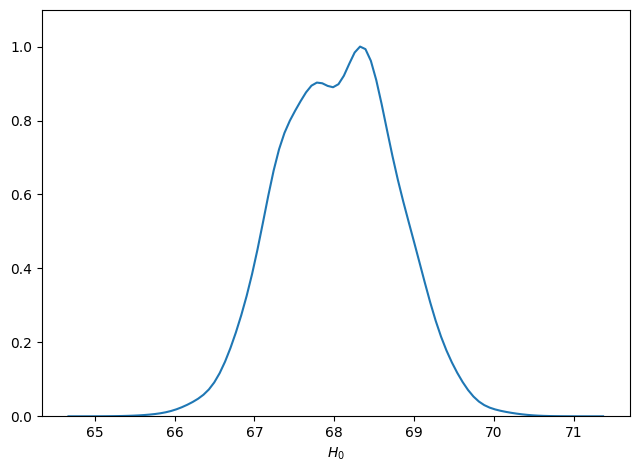

In [ ]:
try:
    from anesthetic import make_1d_axes, read_chains
    import matplotlib.pyplot as plt
    fig, ax = make_1d_axes(['p0'])
    output.plot_2d(ax)
    # chains_file = 'chains/gaussian'
    # samples = read_chains(chains_file)
    # samples.plot_1d(ax)
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    fig.savefig('posterior.pdf')
except ImportError:
    print("Install anesthetic for plotting examples.")